In [67]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
from sklearn.cluster import DBSCAN
import pickle
import glob
from scipy.spatial import ConvexHull
from typing import overload
from sklearn import cluster
from tqdm.notebook import tqdm
import pandas as pd
import scanpy as sc

#### Read in and pad the SID smFISH image

In [47]:
exp = 'avr_24hr'
path_to_imgs = f'/mnt/sata2/alex_storage/Spatiotemporal_Atlas_Ecker/smFISH_images/{exp}'

In [48]:
file_path = os.path.join(path_to_imgs, 'whole_img.tif')
an_image_sid = io.imread(file_path)
sid_image_padded = np.pad(an_image_sid, pad_width=((0, 2000 - np.shape(an_image_sid)[0]%2000), (0,0)))
sid_image_padded = np.pad(sid_image_padded, pad_width=((0, 0), (0,2000 - np.shape(an_image_sid)[1]%2000)))

#### Quantify spots across all images (Hyperparameters will need tuning if using a different set of images)

In [49]:

sid_spots = []
for i_o in range(2000, len(sid_image_padded[0]), 2000):
    for j_o in range(2000, len(sid_image_padded), 2000): 
        iamge_play_sid = sid_image_padded[j_o-2000:j_o, i_o-2000:i_o]

        spots_sid, threshold_sid = detection.detect_spots(  
            images=iamge_play_sid, 
            return_threshold=True,
            threshold=1000,
            log_kernel_size=(1.456, 1.456),
            minimum_distance=(1.456, 1.456))
        sid_spots.append(spots_sid)

In [50]:
ct = 0
new_sid = []
for i_o in range(2000, len(sid_image_padded[0]), 2000):
    for j_o in range(2000, len(sid_image_padded), 2000): 
        for q in np.add(sid_spots[ct], [j_o-2000, i_o-2000]):
            new_sid.append(q)
        ct += 1
new_sid = np.array(new_sid)

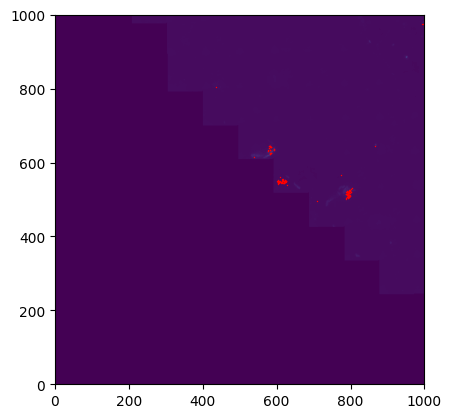

In [51]:
import cv2
downsize = 20
plt.imshow(cv2.resize(sid_image_padded, (sid_image_padded.shape[1]//downsize, sid_image_padded.shape[0]//downsize)))
plt.scatter(new_sid[:, 1]//downsize, new_sid[:, 0]//downsize, s=1, linewidth=0, c='r')
plt.xlim(0, 1000)
plt.ylim(0, 1000)
plt.show()

In [52]:
np.save(f'/mnt/sata2/alex_storage/Spatiotemporal_Atlas_Ecker/smFISH_images/{exp}/detected_spots_original_coords.npy', new_sid)

#### Convert to microns from pixels

In [155]:
exp = 'dc3000_24hr'

In [156]:
new_sid = np.load(f'/mnt/sata2/alex_storage/Spatiotemporal_Atlas_Ecker/smFISH_images/{exp}/detected_spots_original_coords.npy')

In [157]:
if exp == 'avr_24hr':
    path_mm = 'micron_to_mosaic_pixel_transform_avrrpt2_24h.csv'
elif exp == 'avr_9hr':
    path_mm = 'micron_to_mosaic_pixel_transform_avrrpt2_9h.csv'
elif exp == 'mock':
    path_mm = 'micron_to_mosaic_pixel_transform_mock.csv'
elif exp == 'dc3000_24hr':
    path_mm = 'micron_to_mosaic_pixel_transform_kt56.csv'

In [158]:
def get_pixel_size(path: str) -> float:
    file = pd.read_csv(path, index_col=None, header=None)
    return file

pixel_size = get_pixel_size(os.path.join('..', '..', 'data', 'useful_files', 'micron_to_mosaic', path_mm)).values

global_x_pixels = (new_sid[:, 0] + float(pixel_size[0][0].split()[2])) /(float(pixel_size[0][0].split()[0])) 
global_y_pixels = (new_sid[:, 1] + float(pixel_size[1][0].split()[2])) / float(pixel_size[1][0].split()[1])

In [159]:
if exp == 'avr_24hr':
    adata_name = 'avrrpt24'
elif exp == 'avr_9hr':
    adata_name = '9hr_avr'
elif exp == 'mock':
    adata_name = 'mock'
elif exp == 'dc3000_24hr':
    adata_name = 'dc3000'

In [160]:
adata = sc.read(os.path.join('..', '..', 'data', 'integration', adata_name, 'spatial_data.h5ad'))

In [161]:
#assign spots to nearest cell
from scipy.spatial import KDTree
tree = KDTree(adata.obs[['y', 'x']].values)
distances, indices = tree.query(np.array([global_x_pixels, global_y_pixels]).T, k=1)



In [162]:
uniq = np.unique(indices, return_counts=True)
expression_sid = np.zeros(len(adata.obs))
expression_sid[uniq[0]] = uniq[1]
adata.obs['EDS16'] = expression_sid

In [163]:
adata.obsm['X_spatial'] = adata.obs[['x', 'y']].values

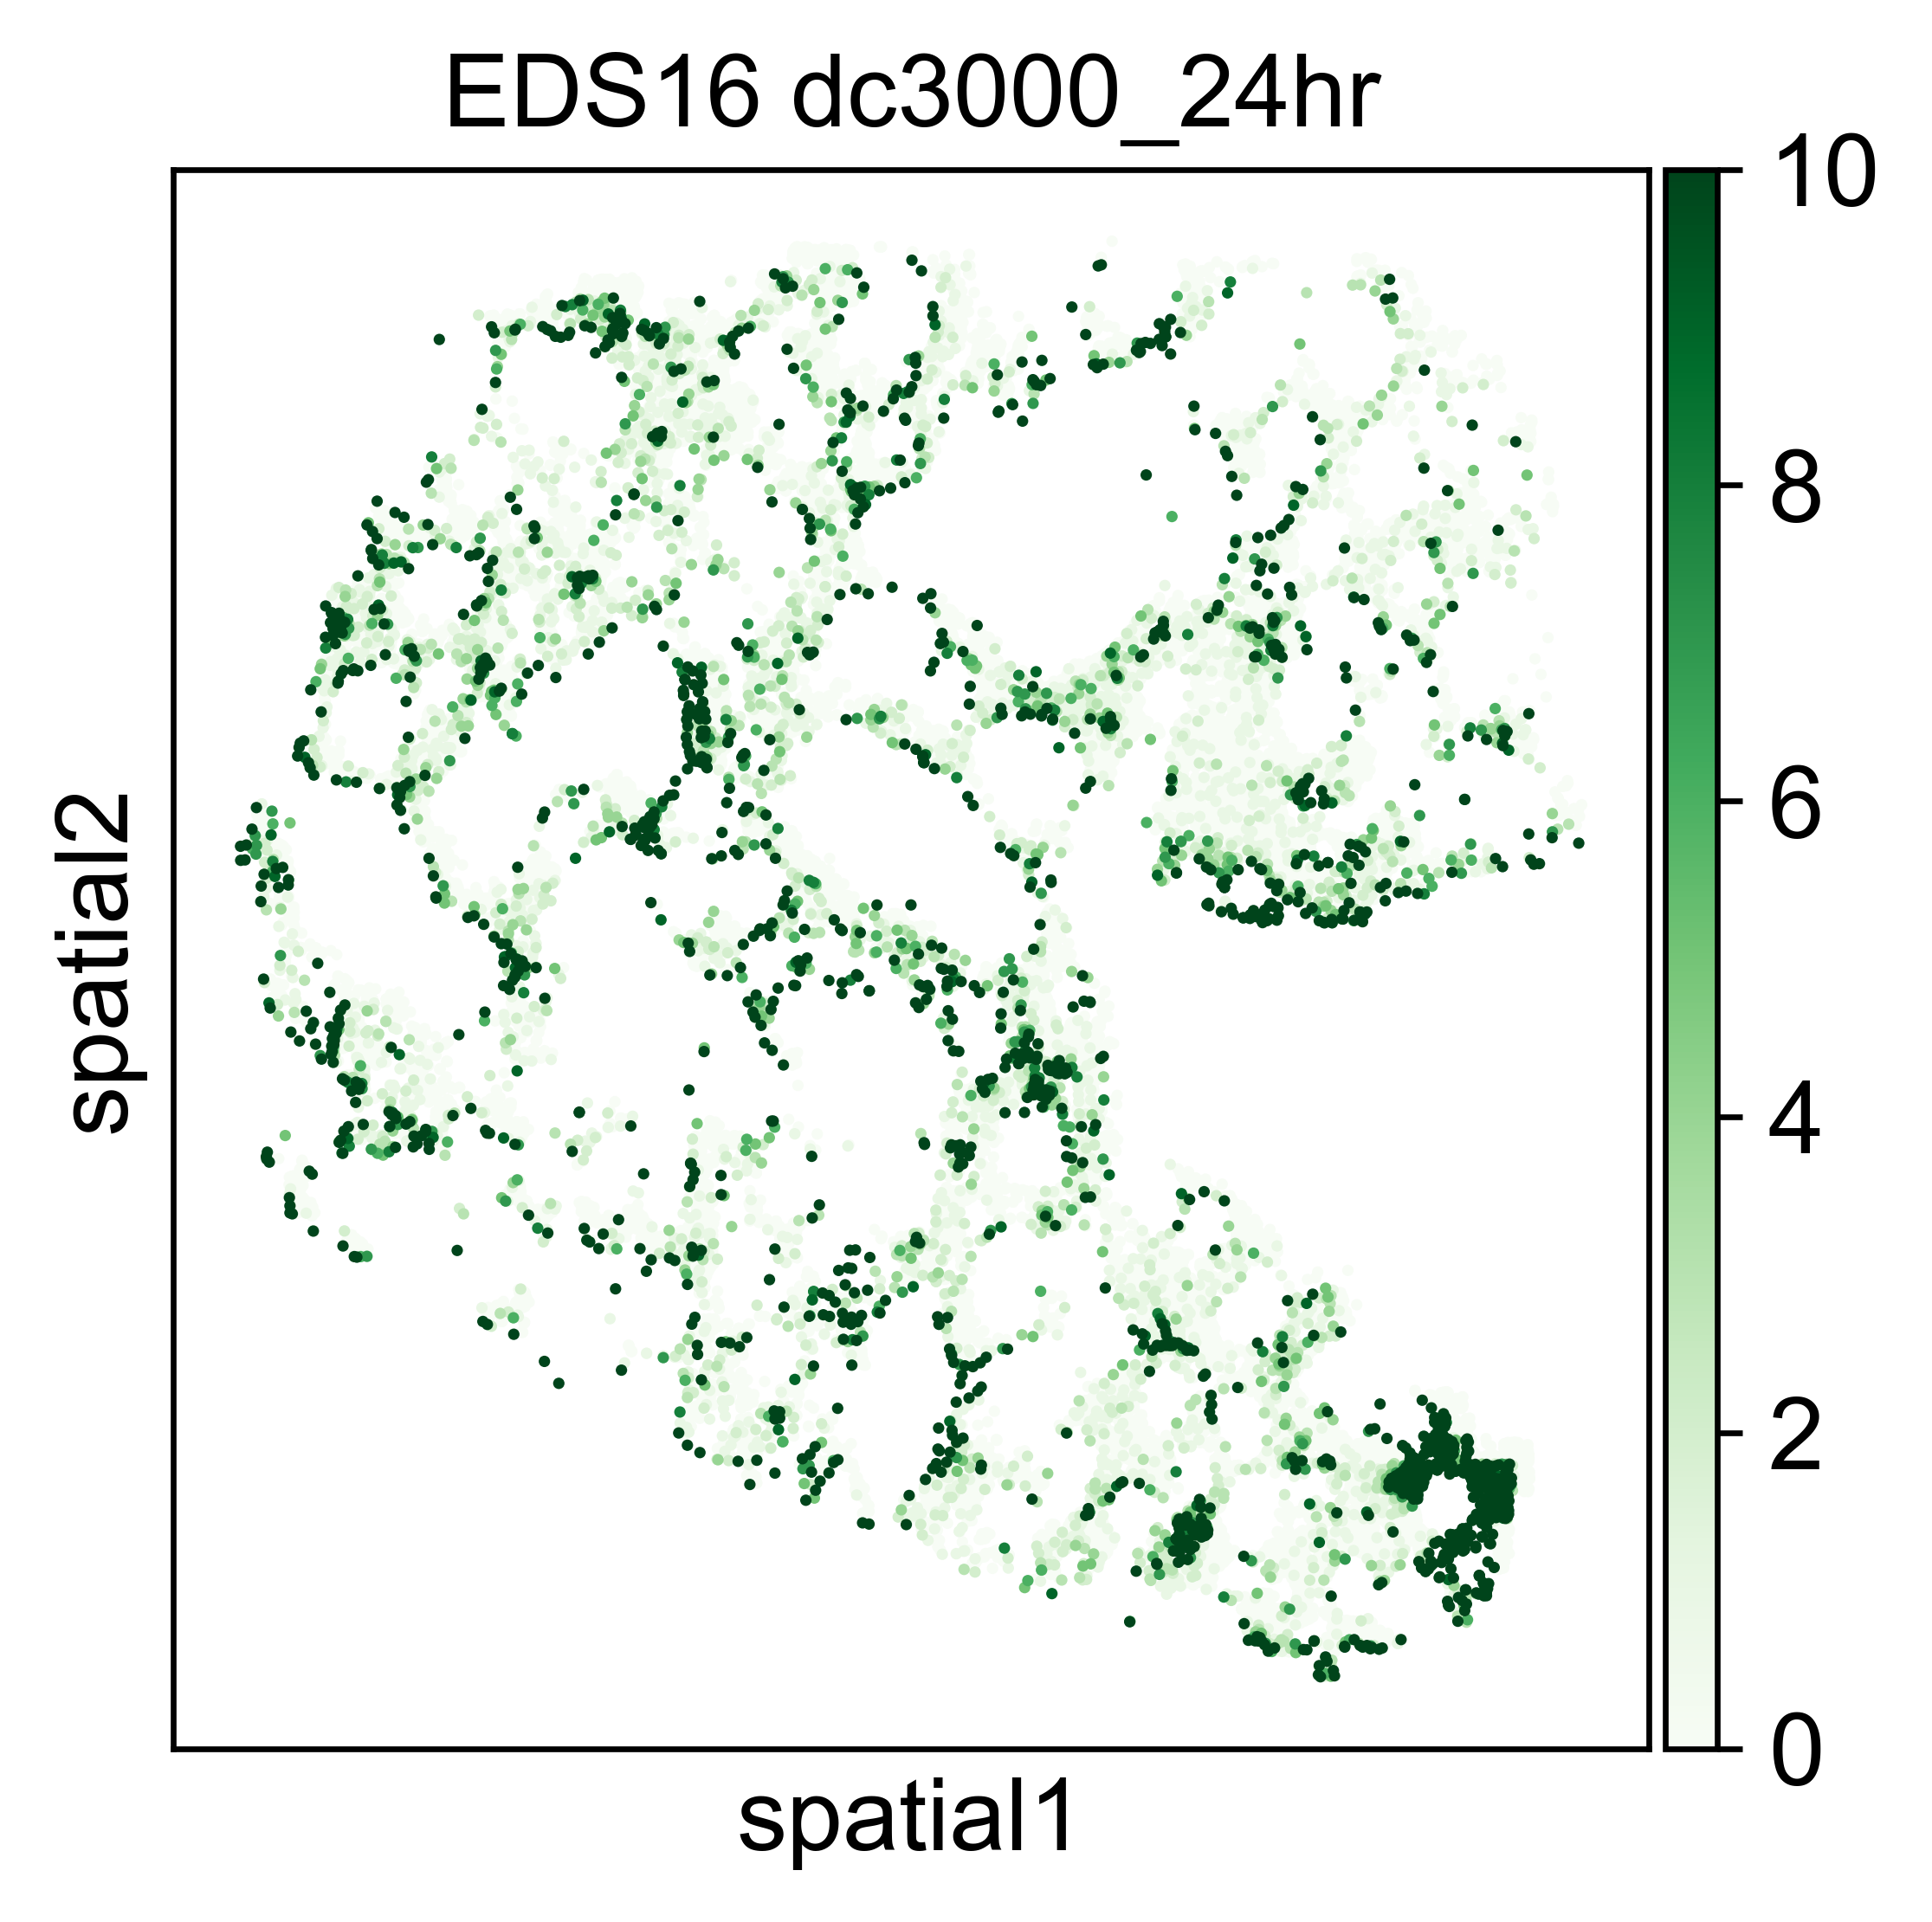

In [164]:
sc.set_figure_params(dpi=300)
fig = sc.pl.embedding(adata, basis='spatial', color='EDS16', size=10, cmap = 'Greens', legend_loc='on data', vmax = 10, title = f'EDS16 {exp}', return_fig=True, show=False)
try:
    os.mkdir(f'../../figures/smFISH')
except:
    pass

try:
    os.mkdir(f'../../figures/smFISH/{exp}')
except:
    pass

fig.savefig(f'../../figures/smFISH/{exp}/EDS16.pdf')
fig.show()